In [1]:
import os
import h5py
import numba
import numpy as np
import pandas as pd
import scipy.integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from hoki.utils.exceptions import HokiFormatError
from pylab import cm
from scipy.optimize import fminbound
import matplotlib.ticker as ticker

In [2]:
data = h5py.File(f"/Users/dillon/Desktop/data.h5", "r")
observations = data['observations']

obs_Ia = observations['Ia']
obs_CCSN = observations['CCSN']
obs_LGRB = observations['LGRB']
obs_PISN = observations['PISN']

In [3]:
event_rates = data['event_rates']
h = event_rates.attrs['h']

In [4]:
desktop_path = '/Users/dillon/Desktop/'

In [5]:
BPASS_files = ['100_100', '100_300', '135_100', '135_300', '135all_100', '170_100', '170_300']
models = ['empmodel', 'harikane22', 'MD', 'TNG', 'EAGLE', 'millimillennium']

In [6]:
events = ['Ia_rates', 'CCSN_rates', 'LGRB_rates', 'PISN_rates']

In [7]:
bpass_file_colors = {
    '100_100': 'red',
    '100_300': 'blue',
    '135_100': 'green',
    '135_300': 'orange',
    '135all_100': 'purple',
    '170_100': 'brown',
    '170_300': 'pink',
}

obs_colors = {
    'Ia': 'grey',
    'CCSN': 'grey',
    'LGRB': 'grey',
    'PISN': 'grey',
}

In [8]:
model_data = {}

for model in models:
    model_data[model] = {}  
    for bpass_file in BPASS_files:
        folder_path = os.path.join(desktop_path, bpass_file)
        file_name = f"{model}_{bpass_file}.h5"
        file_path = os.path.join(folder_path, file_name)

        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as file:
                model_data[model][bpass_file] = {key: file[key][:] for key in file.keys()}

In [9]:
Ia_rates = {}
CCSN_rates = {}
LGRB_rates = {}
PISN_rates = {}

for model in models:
    Ia_rates[model] = {}  
    CCSN_rates[model] = {}  
    LGRB_rates[model] = {}  
    PISN_rates[model] = {}  

    for bpass_file in BPASS_files:
        folder_path = os.path.join(desktop_path, bpass_file)
        file_name = f"{model}_{bpass_file}.h5"
        file_path = os.path.join(folder_path, file_name)

        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as file:
                Ia_rates[model][bpass_file] = file['Ia_rates'][:]
                CCSN_rates[model][bpass_file] = file['CCSN_rates'][:]
                LGRB_rates[model][bpass_file] = file['LGRB_rates'][:]
                PISN_rates[model][bpass_file] = file['PISN_rates'][:]

### Empirical Model

Max difference for Ia: 33093.894421685065 at redshift 0.918225381367763
Values at redshift 0.918225381367763: Upper - 76213.18423101323, Lower - 43119.28980932817
Max difference for CCSN: 915914.9297021639 at redshift 1.5586847070687158
Values at redshift 1.5586847070687158: Upper - 1255302.2134286978, Lower - 339387.2837265338
Max difference for LGRB: 10703.398801782772 at redshift 2.775537281909773
Values at redshift 2.775537281909773: Upper - 11913.801790681104, Lower - 1210.4029888983305
Max difference for PISN: 541.4000526605118 at redshift 2.775537281909773
Values at redshift 2.775537281909773: Upper - 547.2957191590895, Lower - 5.89566649857763


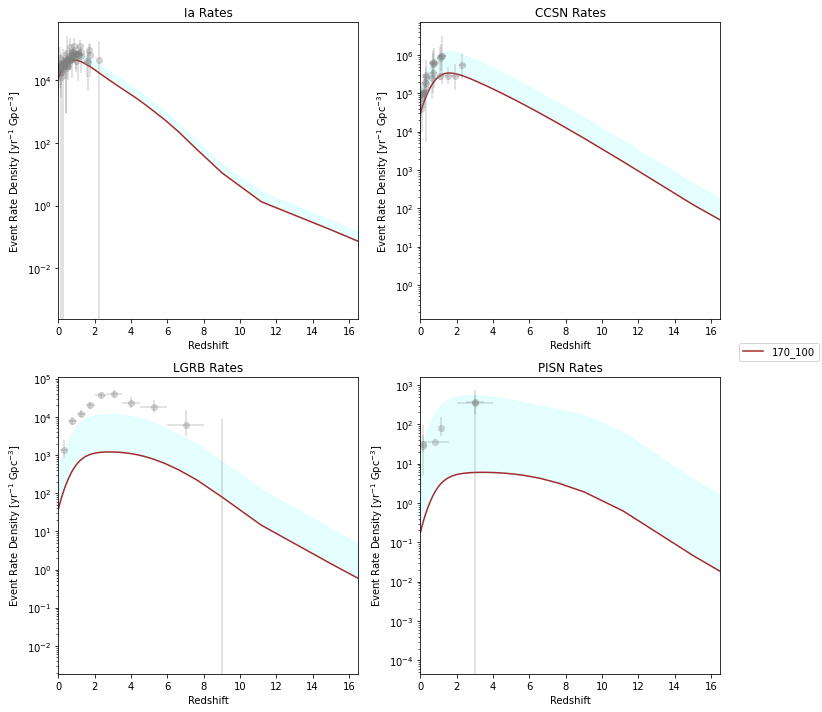

In [45]:
models_to_plot = ['empmodel']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        bpass_file = '170_100'
        rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
        x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]

        all_min_rates = np.min([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)
        all_max_rates = np.max([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)

        max_difference = np.max(all_max_rates - all_min_rates)

        max_difference_index = np.argmax(all_max_rates - all_min_rates)
        max_difference_redshift = x_axis_data[max_difference_index]

        max_difference_values_upper = all_max_rates[max_difference_index]
        max_difference_values_lower = all_min_rates[max_difference_index]

        ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])

        ax.fill_between(x_axis_data, all_min_rates, all_max_rates, color='cyan', alpha=0.1)

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

        print(f"Max difference for {event_type}: {max_difference} at redshift {max_difference_redshift}")
        print(f"Values at redshift {max_difference_redshift}: Upper - {max_difference_values_upper}, Lower - {max_difference_values_lower}")

        if i == 0:
            handles.append(ax.lines[0])
            labels.append(f'{bpass_file}')

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.show()


### Harikane 22

Max difference for Ia: 38670.37741285969 at redshift 1.0520476088017878
Values at redshift 1.0520476088017878: Upper - 90439.10226843072, Lower - 51768.72485557103
Max difference for CCSN: 1110846.0292816865 at redshift 1.9024311624293306
Values at redshift 1.9024311624293306: Upper - 1527259.2838659731, Lower - 416413.2545842866
Max difference for LGRB: 15987.044591962816 at redshift 3.1093017386763346
Values at redshift 3.1093017386763346: Upper - 17805.522305058636, Lower - 1818.4777130958187
Max difference for PISN: 814.5347960805312 at redshift 3.3053766394572954
Values at redshift 3.3053766394572954: Upper - 823.7227664299952, Lower - 9.187970349464017


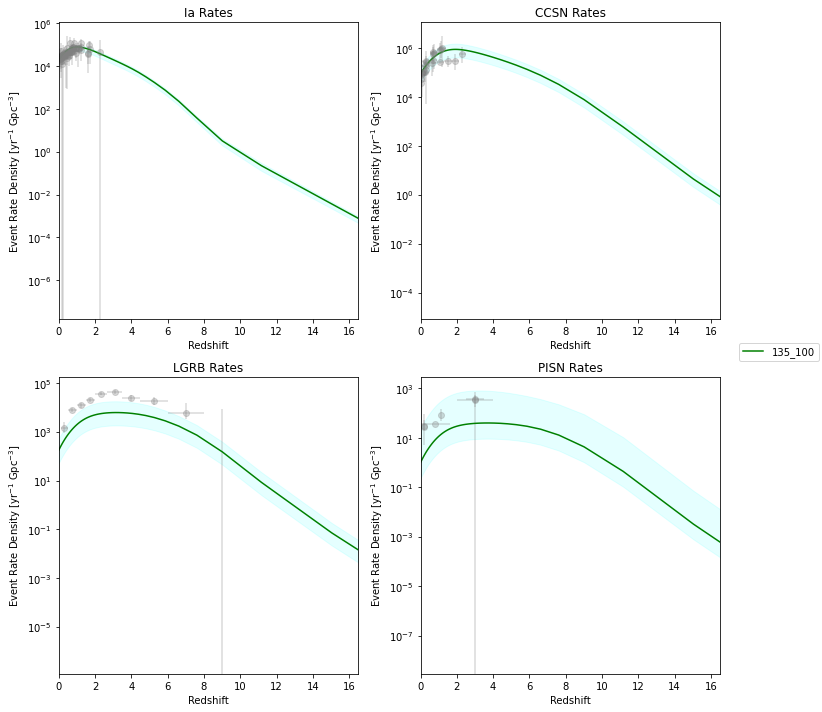

In [47]:
models_to_plot = ['harikane22']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        bpass_file = '135_100'
        rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
        x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]

        all_min_rates = np.min([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)
        all_max_rates = np.max([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)

        max_difference = np.max(all_max_rates - all_min_rates)

        max_difference_index = np.argmax(all_max_rates - all_min_rates)
        max_difference_redshift = x_axis_data[max_difference_index]

        max_difference_values_upper = all_max_rates[max_difference_index]
        max_difference_values_lower = all_min_rates[max_difference_index]

        ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])

        ax.fill_between(x_axis_data, all_min_rates, all_max_rates, color='cyan', alpha=0.1)

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

        print(f"Max difference for {event_type}: {max_difference} at redshift {max_difference_redshift}")
        print(f"Values at redshift {max_difference_redshift}: Upper - {max_difference_values_upper}, Lower - {max_difference_values_lower}")

        if i == 0:
            handles.append(ax.lines[0])
            labels.append(f'{bpass_file}')

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.show()


### TNG

Max difference for Ia: 20822.78331448346 at redshift 1.0887624983599409
Values at redshift 1.0887624983599409: Upper - 45492.0317941547, Lower - 24669.248479671238
Max difference for CCSN: 743209.5571635691 at redshift 2.631982492326683
Values at redshift 2.631982492326683: Upper - 1010316.9311733097, Lower - 267107.3740097406
Max difference for LGRB: 6043.411590498896 at redshift 4.065633896017329
Values at redshift 4.065633896017329: Upper - 6757.427674647281, Lower - 714.0160841483853
Max difference for PISN: 427.3679890999386 at redshift 4.401407604967409
Values at redshift 4.401407604967409: Upper - 432.5499601668463, Lower - 5.181971066907683


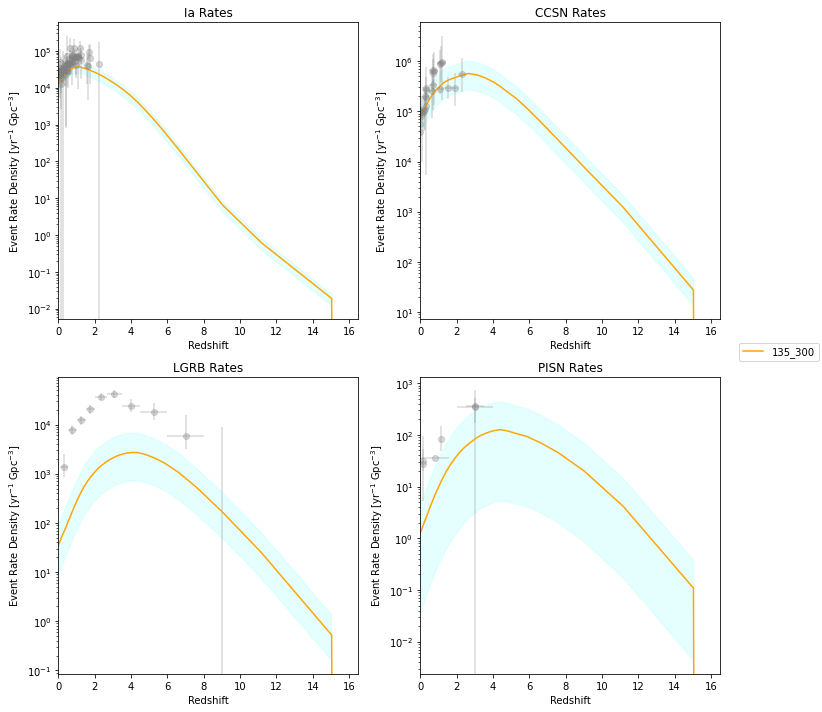

In [48]:
models_to_plot = ['TNG']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        bpass_file = '135_300'
        rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
        x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]

        all_min_rates = np.min([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)
        all_max_rates = np.max([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)

        max_difference = np.max(all_max_rates - all_min_rates)

        max_difference_index = np.argmax(all_max_rates - all_min_rates)
        max_difference_redshift = x_axis_data[max_difference_index]

        max_difference_values_upper = all_max_rates[max_difference_index]
        max_difference_values_lower = all_min_rates[max_difference_index]

        ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])

        ax.fill_between(x_axis_data, all_min_rates, all_max_rates, color='cyan', alpha=0.1)

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

        print(f"Max difference for {event_type}: {max_difference} at redshift {max_difference_redshift}")
        print(f"Values at redshift {max_difference_redshift}: Upper - {max_difference_values_upper}, Lower - {max_difference_values_lower}")

        if i == 0:
            handles.append(ax.lines[0])
            labels.append(f'{bpass_file}')

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.show()


### Madau & Dickinson 

Max difference for Ia: 33117.87255155562 at redshift 1.0520476088017878
Values at redshift 1.0520476088017878: Upper - 77086.67210813823, Lower - 43968.799556582606
Max difference for CCSN: 976594.6855098698 at redshift 1.8251304622140863
Values at redshift 1.8251304622140863: Upper - 1341712.968960105, Lower - 365118.28345023515
Max difference for LGRB: 12484.853806498373 at redshift 2.631982492326683
Values at redshift 2.631982492326683: Upper - 13893.735304443817, Lower - 1408.8814979454432
Max difference for PISN: 630.1511511852955 at redshift 2.631982492326683
Values at redshift 2.631982492326683: Upper - 636.9588255425871, Lower - 6.807674357291559


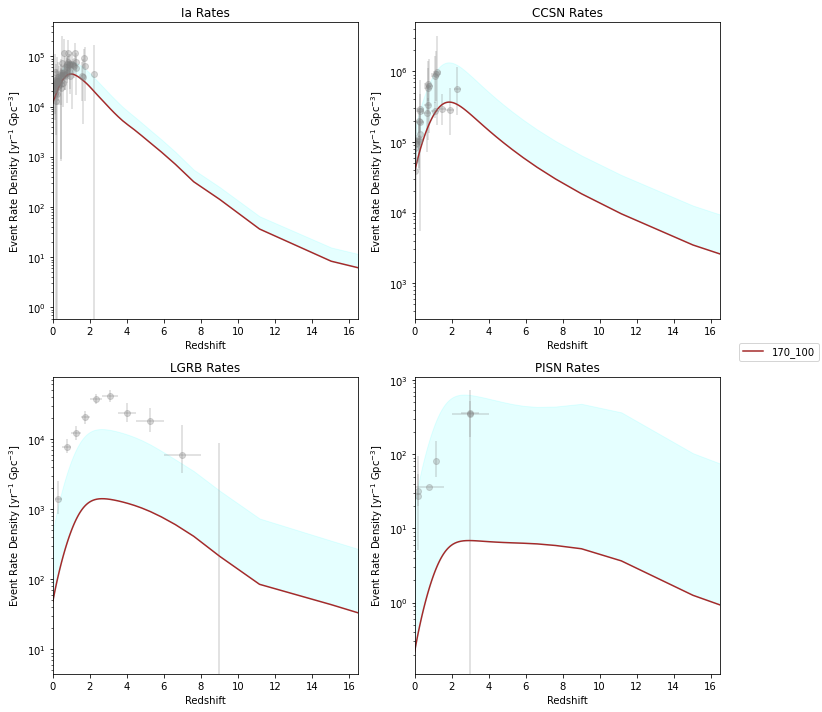

In [49]:
models_to_plot = ['MD']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        bpass_file = '170_100'
        rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
        x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]

        all_min_rates = np.min([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)
        all_max_rates = np.max([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)

        max_difference = np.max(all_max_rates - all_min_rates)

        max_difference_index = np.argmax(all_max_rates - all_min_rates)
        max_difference_redshift = x_axis_data[max_difference_index]

        max_difference_values_upper = all_max_rates[max_difference_index]
        max_difference_values_lower = all_min_rates[max_difference_index]

        ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])

        ax.fill_between(x_axis_data, all_min_rates, all_max_rates, color='cyan', alpha=0.1)

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

        print(f"Max difference for {event_type}: {max_difference} at redshift {max_difference_redshift}")
        print(f"Values at redshift {max_difference_redshift}: Upper - {max_difference_values_upper}, Lower - {max_difference_values_lower}")

        if i == 0:
            handles.append(ax.lines[0])
            labels.append(f'{bpass_file}')

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.show()


### EAGLE

Max difference for Ia: 22414.134240720578 at redshift 1.1667411350334527
Values at redshift 1.1667411350334527: Upper - 51790.03006025836, Lower - 29375.89581953778
Max difference for CCSN: 666157.4633066487 at redshift 1.9849528715121463
Values at redshift 1.9849528715121463: Upper - 914067.3781634009, Lower - 247909.9148567523
Max difference for LGRB: 12707.911469432971 at redshift 3.3053766394572954
Values at redshift 3.3053766394572954: Upper - 14252.00220843569, Lower - 1544.0907390027191
Max difference for PISN: 1210.677022715129 at redshift 5.8669014252737774
Values at redshift 5.8669014252737774: Upper - 1226.8796707756107, Lower - 16.202648060481696


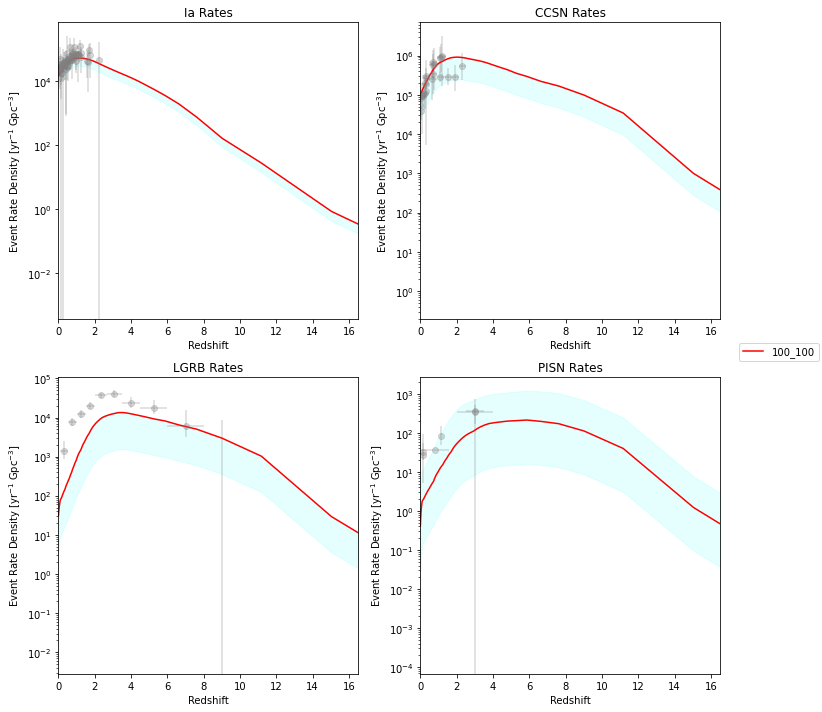

In [51]:
models_to_plot = ['EAGLE']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        bpass_file = '100_100'
        rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
        x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]

        all_min_rates = np.min([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)
        all_max_rates = np.max([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)

        max_difference = np.max(all_max_rates - all_min_rates)

        max_difference_index = np.argmax(all_max_rates - all_min_rates)
        max_difference_redshift = x_axis_data[max_difference_index]

        max_difference_values_upper = all_max_rates[max_difference_index]
        max_difference_values_lower = all_min_rates[max_difference_index]

        ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])

        ax.fill_between(x_axis_data, all_min_rates, all_max_rates, color='cyan', alpha=0.1)

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

        print(f"Max difference for {event_type}: {max_difference} at redshift {max_difference_redshift}")
        print(f"Values at redshift {max_difference_redshift}: Upper - {max_difference_values_upper}, Lower - {max_difference_values_lower}")

        if i == 0:
            handles.append(ax.lines[0])
            labels.append(f'{bpass_file}')

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.show()


### Millimillennium

Max difference for Ia: 31733.503096519293 at redshift 1.2515309062883408
Values at redshift 1.2515309062883408: Upper - 72307.9397413677, Lower - 40574.436644848414
Max difference for CCSN: 1014951.0874088723 at redshift 3.1093017386763346
Values at redshift 3.1093017386763346: Upper - 1394018.1251984478, Lower - 379067.03778957546
Max difference for LGRB: 10687.130880252897 at redshift 4.401407604967409
Values at redshift 4.401407604967409: Upper - 11877.31512138362, Lower - 1190.1842411307243
Max difference for PISN: 580.2588690782725 at redshift 4.401407604967409
Values at redshift 4.401407604967409: Upper - 586.1766437828757, Lower - 5.917774704603122


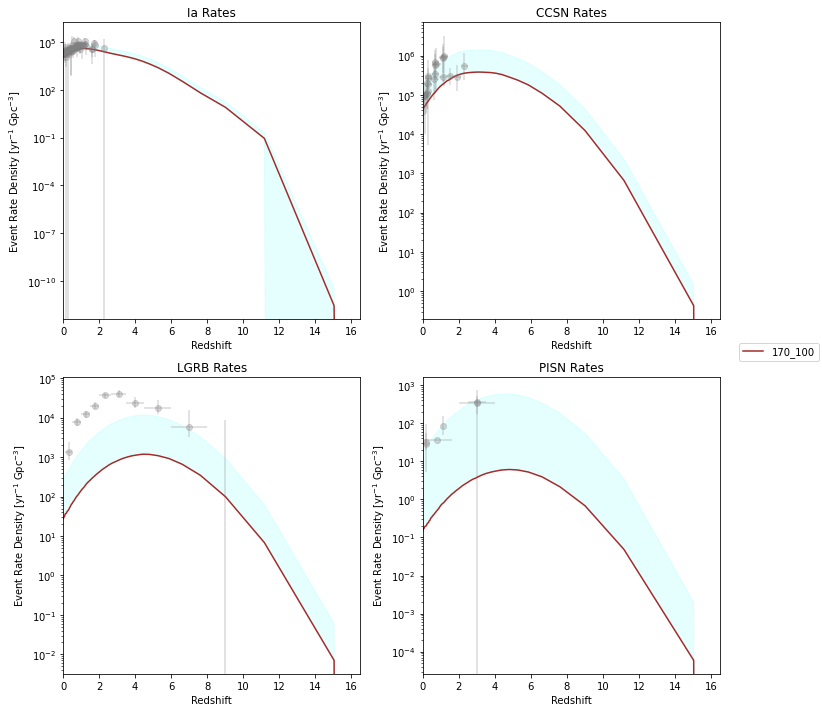

In [52]:
models_to_plot = ['millimillennium']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        bpass_file = '170_100'
        rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
        x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]

        all_min_rates = np.min([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)
        all_max_rates = np.max([globals()[f'{event_type}_rates'][model][bf] for bf in BPASS_files], axis=0)

        max_difference = np.max(all_max_rates - all_min_rates)

        max_difference_index = np.argmax(all_max_rates - all_min_rates)
        max_difference_redshift = x_axis_data[max_difference_index]

        max_difference_values_upper = all_max_rates[max_difference_index]
        max_difference_values_lower = all_min_rates[max_difference_index]

        ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])

        ax.fill_between(x_axis_data, all_min_rates, all_max_rates, color='cyan', alpha=0.1)

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

        print(f"Max difference for {event_type}: {max_difference} at redshift {max_difference_redshift}")
        print(f"Values at redshift {max_difference_redshift}: Upper - {max_difference_values_upper}, Lower - {max_difference_values_lower}")

        if i == 0:
            handles.append(ax.lines[0])
            labels.append(f'{bpass_file}')

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.show()
